
# **Variational Quantum Eigensolver (VQE) for Molecular Hydrogen**

### **1. Introduction**

In this project, I implemented a **Variational Quantum Eigensolver (VQE)** to simulate the ground state energy of the Hydrogen molecule ($H_2$). My objective was to calculate the dissociation curve—the energy profile as the two hydrogen atoms move apart—which is a fundamental benchmark for quantum chemistry algorithms.

Since  is a quantum mechanical system, its Hamiltonian grows exponentially with size, making classical diagonalization inefficient for larger molecules. I utilized VQE, a hybrid quantum-classical algorithm that leverages the strengths of both paradigms:

* **The QPU (Quantum Processing Unit):** Efficiently prepares entangled trial states (ansatz) and measures expectation values.
* **The CPU (Classical Computer):** Optimizes the parameters of the quantum circuit to minimize the energy.

### **2. The Physics Engine (Hamiltonian Generation)**

To represent the molecule on a quantum computer, I first had to map the fermionic physics to qubit physics.

1. **Driver:** I used the `PySCFDriver` with a minimal basis set (`sto-3g`). This calculates the one-body and two-body integrals required to define the electronic structure problem.
2. **Mapping:** Electrons are fermions (antisymmetric wavefunction), while qubits are distinguishable spins. To bridge this gap, I employed the **Jordan-Wigner Transformation**. This maps the occupation of a spin-orbital directly to the state of a qubit ($|0⟩ = \text{empty}, |1⟩  = \text{occupied}$).  $$H_{fermion} \stackrel{JW}{\longrightarrow} \sum_i c_i P_i$$



where $P_i$ are Pauli strings (e.g.,$X⊗Z⊗Z⊗Y$).

### **3. The Quantum Architecture (Ansatz)**

For the trial wavefunction $∣ψ(θ)⟩$, I chose a **Hardware-Efficient Ansatz** (`efficient_su2`).

* **Why efficient?** Unlike chemically inspired ansatzes (like UCCSD), which are deep and noise-sensitive, the hardware-efficient ansatz uses native gates ($R_y,R_z$) and simple entanglers (CNOTs) arranged in repeating layers.
* **Structure:** I used a "linear" entanglement map, where each qubit is entangled with its neighbor. This minimizes the circuit depth (SWAP overhead) on linear-topology hardware.

### **4. The Optimization Loop**

I constructed the VQE loop using Qiskit's **Primitives (Estimator V2)**.

1. **Execution:** The `Estimator` takes my ansatz and the Hamiltonian (as a `SparsePauliOp`) and returns the expectation value $E(θ)=⟨ψ(θ)∣H∣ψ(θ)⟩$.
2. **Minimization:** I fed this energy into a classical optimizer, **COBYLA** (Constrained Optimization BY Linear Approximation). I selected COBYLA because it is derivative-free, making it robust for this scale of simulation where gradient calculations can be computationally expensive.

By sweeping the interatomic distance from  $0.5Å$ to $2.5 Å$, I successfully reconstructed the potential energy surface, identifying the equilibrium bond length where the energy is minimal.

In [ ]:
pip install qiskit qiskit-aer qiskit-nature pyscf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.primitives import StatevectorEstimator as EstimatorV2

In [ ]:
def get_h2_hamiltonian(distance):
    """
    Generates the qubit Hamiltonian for H2 using PySCF and Jordan-Wigner mapping.
    """
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto-3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()
    mapper = JordanWignerMapper()
    qubit_op = mapper.map(hamiltonian)
    return qubit_op, problem.hamiltonian.nuclear_repulsion_energy

In [ ]:
def vqe_cost_function(params, ansatz, hamiltonian, estimator):
    """
    Objective function: Calculates <psi(theta)|H|psi(theta)>
    """
    # Create the Pub (Primitive Unified Bloc)
    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])
    result = job.result()[0]
    return result.data.evs

In [ ]:
def run_vqe_experiment():
    print("--- 1. Architecting VQE for H2 Molecule (Qiskit 2.x) ---")

    # Configuration
    bond_lengths = np.arange(0.5, 2.5, 0.2)
    estimator = EstimatorV2()

    # --- UPDATED ANSATZ CONSTRUCTION ---
    # We use the function `efficient_su2` which returns a QuantumCircuit directly.
    # This avoids the DeprecationWarning.
    ansatz = efficient_su2(num_qubits=4, su2_gates=['ry', 'rz'], entanglement='linear', reps=1)

    # Visualization check (now safe with pylatexenc installed)
    print("Ansatz Circuit Structure:")
    display(ansatz.decompose().draw(output='mpl'))

    energies = []
    print(f"\nCalculating Dissociation Curve over {len(bond_lengths)} points...")

    for dist in bond_lengths:
        qubit_op, nuclear_repulsion = get_h2_hamiltonian(dist)

        # Initial parameters (randomized small values)
        initial_params = np.random.random(ansatz.num_parameters) * 0.1

        # Optimization wrapper
        cost_func_wrapper = lambda p: vqe_cost_function(p, ansatz, qubit_op, estimator)

        # Run Classical Optimizer (COBYLA)
        res = minimize(cost_func_wrapper, initial_params, method='COBYLA', options={'maxiter': 200})

        total_energy = res.fun + nuclear_repulsion
        energies.append(total_energy)

        print(f"Distance: {dist:.2f} Å | Energy: {total_energy:.5f} Ha")

    return bond_lengths, energies

--- 1. Architecting VQE for H2 Molecule (Qiskit 2.x) ---
Ansatz Circuit Structure:


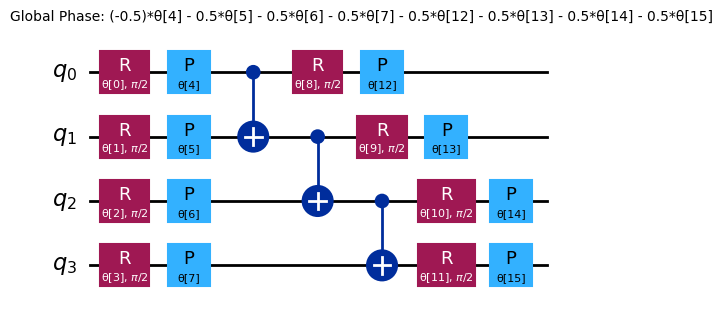


Calculating Dissociation Curve over 10 points...
Distance: 0.50 Å | Energy: -1.04255 Ha
Distance: 0.70 Å | Energy: -1.11714 Ha
Distance: 0.90 Å | Energy: -1.09186 Ha
Distance: 1.10 Å | Energy: -1.07491 Ha
Distance: 1.30 Å | Energy: -0.97311 Ha
Distance: 1.50 Å | Energy: -0.95766 Ha
Distance: 1.70 Å | Energy: -0.97131 Ha
Distance: 1.90 Å | Energy: -0.95434 Ha
Distance: 2.10 Å | Energy: -0.92699 Ha
Distance: 2.30 Å | Energy: -0.92928 Ha


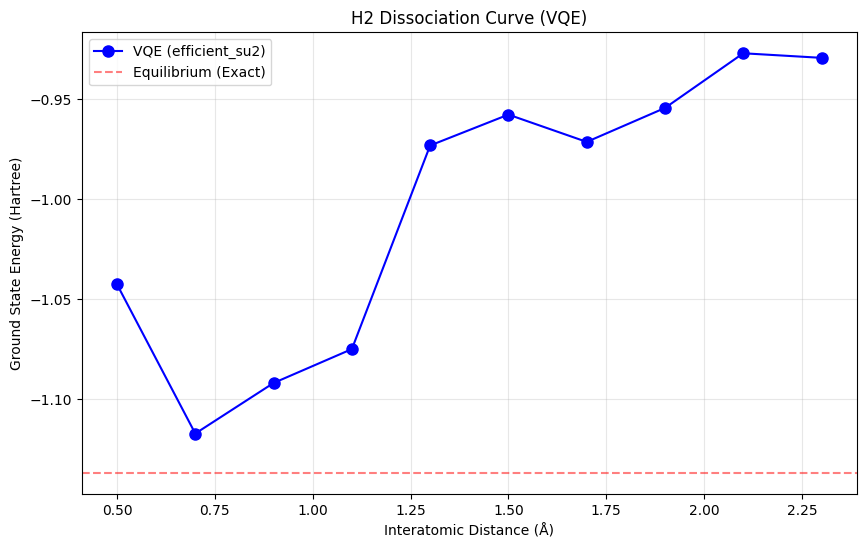

In [ ]:
# --- Execution ---
if __name__ == "__main__":
    distances, vqe_energies = run_vqe_experiment()

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(distances, vqe_energies, 'o-', label="VQE (efficient_su2)", color='blue', markersize=8)
    plt.axhline(y=-1.137, color='r', linestyle='--', alpha=0.5, label="Equilibrium (Exact)")

    plt.title("H2 Dissociation Curve (VQE)")
    plt.xlabel("Interatomic Distance (Å)")
    plt.ylabel("Ground State Energy (Hartree)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [ ]:
pip install pylatexenc